## Initialization and Importing Necessary Libraries

In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import findspark
findspark.init()
findspark.find()
import pyspark
import socket

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from textblob import TextBlob
from pyspark.streaming import StreamingContext

from pyspark.sql.types import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import time
import tweepy
import pandas as pd
from tweepy import OAuthHandler 
from tweepy import Stream


## Twitter API authorization 

In [2]:
### Unique secret keys which provides access to the twitter API 
### ********** SECRET KEYS *****************

consumer_key="Insert here"
consumer_secret="Insert here"
bearer_token="Insert here"
access_token="Insert here"
access_secret="Insert here"

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
redirect_url = auth.get_authorization_url()
print(redirect_url)

https://api.twitter.com/oauth/authorize?oauth_token=zduuMgAAAAABXvBtAAABfnLy1ww


In [4]:
api = tweepy.API(auth)

## Creating a Spark Session

In [5]:
### Creates a spark session 
### set name of the app and configurations 
conf = pyspark.SparkConf().setAppName('sentimentanalysis').setMaster('local[2]')
sc = pyspark.SparkContext('local[4]',conf=conf)
spark = SparkSession(sc)
sqlcontext=SQLContext(sc)

In [6]:
spark

## Defining Twitter Listner Class

In [7]:
### Stream listener Class establishes a streaming session and allows to 
### read tweets in real time from the twitter API
### Useful for reading a very large number of tweets 
### Functions can be added in the stream listner class as requirement changes

class MyStreamListener(tweepy.Stream):
    
    # time_limit specifies the time duration in which tweets are to be downloaded in real time
    # User can specify the time limit according to the needs
    # time module gives the current time 
    def __init__(self,time_limit):
        self.start_time = time.time()
        self.limit = time_limit
        # hashtag_list stores all the hashtags as a list
        self.hashtag_list=[]
        # tweet_list stores all the tweets as a list 
        self.tweet_list=[]
        # stream instance gets authorized to stream tweets
        super(MyStreamListener, self).__init__(consumer_key,consumer_secret,\
                                               access_token,access_secret)
    
    def on_connect(self):
        print("Connected to Twitter API.")
        
    def on_status(self, status):
        # Tweet ID
        tweet_id = status.id
        # User ID
        user_id = status.user.id
        # Username
        username = status.user.name
        # Tweet
        
        if status.truncated == True:
            tweet = status.extended_tweet['full_text']
            # tweet list is appended with a new tweet
            self.tweet_list.append(tweet)
            hashtags = status.extended_tweet['entities']['hashtags']
        else:
            tweet = status.text
            # tweet list is appended with a new tweet
            self.tweet_list.append(tweet)
            hashtags = status.entities['hashtags']
        
        print(tweet)
        
        # Read hastags
        hashtags=read_hashtags(hashtags)
        # Create Hashtags list
        for ele in hashtags:
            self.hashtag_list.append(ele)
       
        # Retweet count
        retweet_count = status.retweet_count
        # Language
        lang = status.lang
        # If the time limit is reached the stream session is disconnected     
        if (time.time() - self.start_time) > self.limit:
            print(time.time(), self.start_time, self.limit)
            MyStreamListener.disconnect(self)
            return False
             
    def on_error(self, status_code):
        if status_code == 420:
            # Returning False in on_data disconnects the stream
            MyStreamListener.disconnect(self)
            return False



In [8]:
### Function that reads hashtags, indecies and returns only the hashtags in the form of a list
def read_hashtags(tag_list):
    hashtags = []
    for tag in tag_list:
        hashtags.append(tag['text'])
    return hashtags

## Data Cleaning and Pre-processing Functions

In [9]:
### Function to remove emoticons, symbols, flags and irrelevant objects from the tweets
import re
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

remove_emojis_udf= udf(lambda x: remove_emojis(x),StringType())

In [10]:
#### Function to remove https, RT, hashtag symbols etc from the tweets
#### Pre-processing and cleaning of tweet data
def preprocessing(lines):
    words = lines.select(explode(split(lines.value, "t_end")).alias("text"))
    words = words.na.replace('', None)
    words = words.na.drop("any")
    words = words.distinct()
    words = words.withColumn('text', regexp_replace('text', r'http\S+', ''))
    words = words.withColumn('text', regexp_replace('text', '@\w+', ''))
    words = words.withColumn('text', regexp_replace('text', '#', ''))
    words = words.withColumn('text', regexp_replace('text', 'RT', ''))
    words = words.withColumn('text', regexp_replace('text', ':', ''))
    words = words.withColumn('text', regexp_replace('text', "[^A-Za-z0-9]+"," "))
    words = words.withColumn('text', regexp_replace('text', '  ', ' '))
    words = words.withColumn('text', regexp_replace('text', '   ', ' '))
    words = words.withColumn('text', regexp_replace('text', '-', ''))
    words = words.withColumn('text', regexp_replace('text', '&amp;', ''))
    words = words.withColumn('text', regexp_replace('text', '&quot;', ''))
    words = words.withColumn('text', regexp_replace('text', '&gt;', ''))
    words = words.withColumn('text', regexp_replace('text', '&it;', ''))
    words = words.withColumn('text', lower(words["text"]))
    words = words.withColumn('text', remove_emojis_udf("text"))
    #words = words.withColumn('text', tweets_translateudf("text"))
    
    return words

## Text Classification and Sentiment Analysis Functions

In [11]:
# text classification
### Textblob is used here for sentiment analysis
### Important tool for NLP
def polarity_detection(text):
    return TextBlob(text).sentiment.polarity
def subjectivity_detection(text):
    return TextBlob(text).sentiment.subjectivity
def getSentimentScore(text):
    analyzer = SentimentIntensityAnalyzer()
    score = analyzer.polarity_scores(text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    if neg > pos:
        return  "negative"
    elif pos > neg:
        return "positive"
    else:
        return "neutral"

def text_classification(words):
    # polarity detection
    polarity_detection_udf = udf(polarity_detection, StringType())
    words = words.withColumn("polarity", polarity_detection_udf("text"))
    # subjectivity detection
    subjectivity_detection_udf = udf(subjectivity_detection, StringType())
    words = words.withColumn("subjectivity", subjectivity_detection_udf("text"))
    # Sentiment score
    getSentimentScore_udf=udf(lambda x: getSentimentScore(x),StringType())
    words = words.withColumn("sentiment", getSentimentScore_udf("text"))
    return words        
                
                

### Create a Twitter Stream to read tweets and respective hashtags
#### Tracks tweets based off a keyword and language for a specific time frame

In [12]:
keyword = input("Please enter keyword or hashtag to search: ")
stream_time_limit = int(input ("Please enter the stream time limit in seconds: "))
lang = input("Please enter the tweets language filter: ")

Please enter keyword or hashtag to search: Ronaldo
Please enter the stream time limit in seconds: 500
Please enter the tweets language filter: en


In [13]:
### Instantiates the stream object that creates a stream session 
### Tweets are filtered w.r.t keyword/hashtag and language. 
### Stream session is disconnect as soon as the stream time limit has been reached
twitter_stream = MyStreamListener(time_limit=stream_time_limit)
twitter_stream.filter(track=[keyword],languages=[lang])

Connected to Twitter API.
RT @MUFCScoop: Cristiano Ronaldo is set to leave Manchester United in the summer if the club do not qualify for the Champions League. There…
RT @goal: Australian tennis star Nick Kyrgios hit the Ronaldo celebration after winning his first match at the Australian Open 🎾 https://t.…
RT @CristianoXtra_: Dani Alves:

"You can doubt about signing a 38-year-old player, but not if your name is Dani Alves, Messi, Cristiano Ro…
RT @cr7raprhymes: Cristiano Ronaldo and Robert Lewandowski are the only players to win back to back FIFA The Best Awards. 

Football Royalt…
RT @goal: Australian tennis star Nick Kyrgios hit the Ronaldo celebration after winning his first match at the Australian Open 🎾 https://t.…
RT @SkySportsPL: "We play for the same team, football." ⚽❤️

Pele congratulates Cristiano Ronaldo for receiving The Best FIFA Special Award…
RT @FootballFunnnys: 🗣️ Cristiano Ronaldo on Sporting Lisbon:

"I will retire there. I have to give it to them even if it is one

RT @FIFAWorldCup: One of the all-time greats 🙌  🏆  

Here’s #TheBest FIFA Special Award winner @Cristiano Ronaldo on breaking records and l…
How Man Utd will line up vs Brentford. #BREMUN #MUFC 
                          
                          De Gea
   Dalot    Varane      Lindelof     Telles
                           Matic
                 Bruno         Fred
   Sancho         Ronaldo            Martial
@OdegaardEsque @DerKaiserBM No one is stopping Ronaldo and Messi from scoring. Maybe man utd is stoping Ronaldo but Messi is in psg 11 points clear on the 1st place trio with Mbappe and Neymar, that's only his fault that he scored only 1 league goal.
RT @OddsOnFPL: It seems like Harry Maguire got in trouble with his FPL team after transferring out Cristiano Ronaldo this gameweek.

His FP…
RT @Letter_to_Jack: “I didn’t vote Lewandoski because he has not one anything for Germany” 

This is just the thinking of one of the 176 jo…
@toby7_ @Cristiano LOL literally the worst thing you c

RT @goal: Australian tennis star Nick Kyrgios hit the Ronaldo celebration after winning his first match at the Australian Open 🎾 https://t.…
RT @thefootyarena: If Cristiano Ronaldo scores ANYTIME against Brentford tonight, we'll give away a brand new PlayStation 5 console + a FIF…
Seems Ronaldo is going to play
@NishadKK6 @mhan_blak @ThatsSketchyy @balladdict17 @CristianoXtra_ i agree, i never said Messi is finished. His output hasn’t been great this season but it’s too early to tell. Although in all fairness Ronaldo had 53 G/A last season so not far off and he’s 2 and a half years older
@MUF @Brentford 2x tickets available that I'm selling for Brentford vs Manchester united. DM
#brentford #man united #premierleague #Ronaldo
@lfctumble @_Hxzzaa Just sums up a Liverpool fan, No one has mentioned Ronaldo not even Man united and u say “penaldo” 😂
RT @thefootyarena: If Cristiano Ronaldo scores ANYTIME against Brentford tonight, we'll give away a brand new PlayStation 5 console + a FIF…
RT 

Love the kid, but not benching Ronaldo. Unless youre playing him on the left benching our Charity Chamakh!
RT @Messismo__: So you’re telling me Messi is the leading goal scorer of the decade, and also the top assister of the decade, while also co…
@stopthatdegea @barcelionela @Serqcs @Peak_Jr446 @amitrmfc 45 yard goals
Ronaldo 
- 2
Pessidog 
-0
RT @IFTVofficial: Today is Ivan Zamorano’s birthday, the famous 1+8…

At the time, Ronaldo wore the 10 shirt on Inter and Zamorano wore 9.…
RT @goal: Lionel Messi reaches 300m+ followers on Instagram 🤳

Cristiano Ronaldo is currently sat on 392m 📱 https://t.co/DVkE8srbYO
RT @Sommerfield19: *What’s the difference between Ronaldo and time?*

Time passes.
@utd_Lewis these ronaldo fans have awful ball knowledge 😭😭😭
Andy Murray in the mud
RT @goal: Lionel Messi reaches 300m+ followers on Instagram 🤳

Cristiano Ronaldo is currently sat on 392m 📱 https://t.co/DVkE8srbYO
RT @goal: Lionel Messi reaches 300m+ followers on Instagram 🤳

Cristiano Ronaldo is

RT @thefootyarena: If Cristiano Ronaldo scores ANYTIME against Brentford tonight, we'll give away a brand new PlayStation 5 console + a FIF…
RT @Eyeswid04387971: Casillas never voted for Messi during 08-12. Ronaldo left Portugal captaincy so that Bruno Alves can vote for him. Sam…
RT @Betfair: 🎉 It's competition time! We're giving away 5 x £10 free bets!

Leicester v Spurs
Brentford v Man Utd

⚽ To be in with a chance…
RT @TotalRonnie: Sergio Ramos: “Cristiano Ronaldo is the most important player in the history of Real Madrid.” https://t.co/1o4lUur6iE
Nice having our pal @rioferdy5 at the offices today exciting times ahead. 

Stay tuned to see what’s next @roberto_rudie @aix_capital @official_anfa 

#football #soccer #sports #futbol #fifa #sport #premierleague #africanfootball #championsleague #ronaldo #like #follow #futebol https://t.co/7tlrerRVoN
RT @Betfair: 🎉 It's competition time! We're giving away 5 x £10 free bets!

Leicester v Spurs
Brentford v Man Utd

⚽ To be in with a chance

Stream connection closed by Twitter


RT @goal: Australian tennis star Nick Kyrgios hit the Ronaldo celebration after winning his first match at the Australian Open 🎾 https://t.…
1642606560.2139485 1642606058.421151 500


### Creating tweets and hashtags dataframes based off the streamed tweets

In [14]:
### Stream object is accessed to read the hashtag list containing hashtags from all the tweets
### Hashtags list is the converted into a dataframe for further tasks
hashtags_df=spark.createDataFrame(twitter_stream.hashtag_list,StringType())

In [15]:
### Streamlistner object is accessed again to create a dataframe from the tweets list
### tweet_list contains all the downloaded tweets
tweets_df=spark.createDataFrame(twitter_stream.tweet_list,StringType())

In [16]:
### Displays the tweets extracted in a dataframe
tweets_df.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                        |
+---------------------------------------------------------------------------------------------------------------------------------------------+
|RT @MUFCScoop: Cristiano Ronaldo is set to leave Manchester United in the summer if the club do not qualify for the Champions League. There… |
|RT @goal: Australian tennis star Nick Kyrgios hit the Ronaldo celebration after winning his first match at the Australian Open 🎾 https://t.…|
|RT @CristianoXtra_: Dani Alves:

"You can doubt about signing a 38-year-old player, but not if your name is Dani Alves, Messi, Cristiano Ro… |
|RT @cr7raprhymes: Cristiano Ronaldo and Robert Lewandowski are the only players to win back to back FIFA The Best Awards. 

Football Roy

In [17]:
### Tweets dataframes Preprocessing and data cleaning
tweets_df=preprocessing(tweets_df)

In [18]:
### repartioning the data to avoid time out issues considering the volume of data
### Without using repartition error may occur considering the volume of tweets
tweets_df=tweets_df.repartition(1)

In [19]:
### Displays the cleaned tweets
tweets_df.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| lionel messi reaches 300m followers on instagram cristiano ronaldo is currently sat on 392m                                                                                                                                 |
|ribery on the messi vs ronaldo debate                                                                  

In [20]:
### Sentiment analysis on the cleaned data/tweets
tweets = text_classification(tweets_df)

In [21]:
### Sentiment analysis results
tweets.show()

+--------------------+-------------------+-------------------+---------+
|                text|           polarity|       subjectivity|sentiment|
+--------------------+-------------------+-------------------+---------+
| lionel messi rea...|                0.0|                0.4| positive|
|ribery on the mes...|                0.0|                0.0|  neutral|
|how man utd will ...|                0.0|                0.0|  neutral|
| ronaldo scoring ...|                0.0|                0.0|  neutral|
|messi is the goat...|                0.0|                0.0|  neutral|
| cristiano ronald...| 0.4285714285714286| 0.6607142857142857| positive|
| haha angry poor ...|-0.2333333333333333| 0.6333333333333333| positive|
| ronaldo concept ...|                0.0|                0.0| positive|
| a special trophy...|0.35714285714285715| 0.5714285714285714| positive|
| so you re tellin...|                0.5|                0.5| positive|
| siuuuuu maja mar...|                0.0|         

In [22]:
### Overall Sentiment
sentiment_result=tweets.groupBy("sentiment").count()
sentiment_result.show()

+---------+-----+
|sentiment|count|
+---------+-----+
| positive|   88|
|  neutral|   65|
| negative|   34|
+---------+-----+



In [24]:
### Plotting a pie chart of the resulting sentiments
from pandas.plotting import table
import matplotlib.pyplot as plt
data=sentiment_result.toPandas()
ax1 = plt.subplot(121, aspect='equal')
data.plot(kind='pie', y = 'count', ax=ax1, autopct='%1.1f%%', figsize=(15,5),
 startangle=45, shadow=True, labels=data['sentiment'], legend = False, fontsize=10)

# plot table
ax2 = plt.subplot(122)
plt.axis('off')
tbl = table(ax2, data, loc='center')
tbl.scale(1,3)
tbl.auto_set_font_size(False)
tbl.set_fontsize(15)
plt.show()

In [25]:
### Analyzing the hashtags from the streamed tweets
hashtags_df.withColumn("value",lower("value"))\
.groupBy("value").count().sort("count",ascending=False).show(10)
ht_df=hashtags_df.withColumn("value",lower("value"))\
.groupBy("value").count().sort("count",ascending=False).head(10)
ht_df=pd.DataFrame(ht_df,columns=["Hashtag","count"])


+--------------------+-----+
|               value|count|
+--------------------+-----+
|                mufc|   12|
|              bremun|    8|
|             ronaldo|    3|
|       premierleague|    2|
|             thebest|    2|
|thesecondstep_cha...|    2|
|              트레저|    2|
|            treasure|    2|
|           legendary|    2|
|                 fpl|    1|
+--------------------+-----+
only showing top 10 rows



<AxesSubplot:xlabel='Hashtag'>

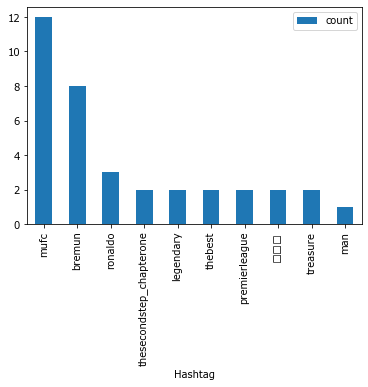

In [27]:
ht_df.plot.bar(x="Hashtag",y="count")
